<a href="https://www.kaggle.com/code/jasnatomasovi/london-bike-share-maps-and-predictions?scriptVersionId=185351426" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualizations
import matplotlib.pyplot as plt # visualizations
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/london-bike-share-station-locations/Station locations.csv
/kaggle/input/london-bike-share-usage-dataset/LondonBikeJourneyAug2023.csv


In [2]:
df = pd.read_csv('/kaggle/input/london-bike-share-usage-dataset/LondonBikeJourneyAug2023.csv')
df.head()

,Number,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration,Total duration (ms)
0,132825189,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",8/1/2023 0:17,1059,"Albert Embankment, Vauxhall",23715,CLASSIC,16m 46s,1006663
1,132825190,8/1/2023 0:00,1190,"Kennington Lane Rail Bridge, Vauxhall",8/1/2023 0:17,1059,"Albert Embankment, Vauxhall",41267,CLASSIC,16m 47s,1007128
2,132825191,8/1/2023 0:00,983,"Euston Road, Euston",8/1/2023 0:11,3500,"Baldwin Street, St. Luke's",53180,CLASSIC,11m 6s,666395
3,132825192,8/1/2023 0:01,3479,"Old Brompton Road, South Kensington",8/1/2023 0:12,1140,"Grosvenor Road, Pimlico",53431,CLASSIC,11m 53s,713059
4,132825193,8/1/2023 0:01,1219,"Lower Marsh, Waterloo",8/1/2023 0:17,200056,"Vauxhall Walk, Vauxhall",54758,CLASSIC,16m 3s,963786


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776527 entries, 0 to 776526
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Number                776527 non-null  int64 
 1   Start date            776527 non-null  object
 2   Start station number  776527 non-null  int64 
 3   Start station         776527 non-null  object
 4   End date              776527 non-null  object
 5   End station number    776527 non-null  int64 
 6   End station           776527 non-null  object
 7   Bike number           776527 non-null  int64 
 8   Bike model            776527 non-null  object
 9   Total duration        776527 non-null  object
 10  Total duration (ms)   776527 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 65.2+ MB


# Data Preprocessing

# Latitude and Longitude

In [4]:
# I found stations' latitudes and longitudes online and saved it and uploaded it as a separate .csv file
stationlocdf = pd.read_csv('/kaggle/input/london-bike-share-station-locations/Station locations.csv')
stationlocdf.head()


,Station Name,Latitude,Longitude,Easting,Northing
0,"River Street, Clerkenwell",51.5292,-0.109971,531202.520,182832.020
1,"Phillimore Gardens, Kensington",51.4996,-0.197574,525207.070,179391.860
2,"Christopher Street, Liverpool Street",51.5213,-0.084606,532984.810,182001.530
3,"St. Chad's Street, King's Cross",51.5301,-0.120974,530436.760,182911.990
4,"Sedding Street, Sloane Square",51.4931,-0.156876,528051.649,178742.097


In [5]:
# Manually correct misspelled location names in a DataFrame
corrections = {
    "Kennington Road  , Vauxhall": "Kennington Road, Vauxhall",
    "Leonard Circus , Shoreditch": "Leonard Circus, Shoreditch",
    "New Road 1 , Whitechapel": "New Road 1, Whitechapel",
    "Tower Gardens , Tower": "Tower Gardens, Tower",
    "Park Lane , Hyde Park": "Park Lane, Hyde Park",
    "Doric Way , Somers Town": "Doric Way, Somers Town",
    "Cartwright Gardens , Bloomsbury": "Cartwright Gardens, Bloomsbury",
    "Vauxhall Bridge , Pimlico": "Vauxhall Bridge, Pimlico",
    "Bayley Street , Bloomsbury": "Bayley Street, Bloomsbury",
    "Montserrat Road , Putney": "Montserrat Road, Putney",
    "Gower Place , Euston": "Gower Place, Euston",
    "Ampton Street , Clerkenwell": "Ampton Street, Clerkenwell",
    "Earnshaw Street , Covent Garden": "Earnshaw Street, Covent Garden",
    "London Zoo,  The Regent's Park": "London Zoo, The Regent's Park",
    "Guilford Street , Bloomsbury": "Guilford Street, Bloomsbury",
    "Finsbury Square , Moorgate": "Finsbury Square, Moorgate",
    "Westfield Southern Terrace ,Shepherd's Bush": "Westfield Southern Terrace, Shepherd's Bush",
    "Finsbury Library , Finsbury": "Finsbury Library, Finsbury",
    "Soho Square , Soho": "Soho Square, Soho",
    "Northington Street , Holborn": "Northington Street, Holborn",
    "Wellington Street , Strand": "Wellington Street, Strand",
    "Parson's Green , Parson's Green": "Parson's Green, Parson's Green",
    "Theobald's Road , Holborn": "Theobald's Road, Holborn",
    "Bell Street , Marylebone": "Bell Street, Marylebone",
    "Regent's Row , Haggerston": "Regent's Row, Haggerston",
    "Lancaster Gate , Bayswater": "Lancaster Gate, Bayswater",
    "Greycoat Street , Westminster": "Greycoat Street, Westminster",
    "Princedale Road , Holland Park": "Princedale Road, Holland Park",
    "High Holborn , Covent Garden": "High Holborn, Covent Garden",
    "Drummond Street , Euston": "Drummond Street, Euston",
    "Dunston Road , Haggerston": "Dunston Road, Haggerston",
    "Gaywood  Street, Elephant & Castle": "Gaywood Street, Elephant & Castle",
    "River Street , Clerkenwell": "River Street, Clerkenwell",
    "Rodney Road , Walworth": "Rodney Road, Walworth",
    "Long Lane , Bermondsey": "Long Lane, Bermondsey",
    "Wenlock Road , Hoxton": "Wenlock Road, Hoxton",
    "Calshot Street , King's Cross": "Calshot Street, King's Cross",
    "Eversholt Street , Camden Town": "Eversholt Street, Camden Town",
    "Murray Grove , Hoxton": "Murray Grove, Hoxton",
    "Webber Street , Southwark": "Webber Street, Southwark",
    "Newgate Street , St. Paul's": "Newgate Street, St. Paul's",
    "Stainsby Road , Poplar": "Stainsby Road, Poplar",
}

# Update the DataFrame with corrections
df['Start station'] = df['Start station'].replace(corrections)
df['End station'] = df['End station'].replace(corrections)

In [6]:
# Merge the two DataFrames on the 'Station Name' column
df['Station Name'] = df['Start station']
df = pd.merge(df, stationlocdf, on='Station Name', how='left')

# Display the merged DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776527 entries, 0 to 776526
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Number                776527 non-null  int64  
 1   Start date            776527 non-null  object 
 2   Start station number  776527 non-null  int64  
 3   Start station         776527 non-null  object 
 4   End date              776527 non-null  object 
 5   End station number    776527 non-null  int64  
 6   End station           776527 non-null  object 
 7   Bike number           776527 non-null  int64  
 8   Bike model            776527 non-null  object 
 9   Total duration        776527 non-null  object 
 10  Total duration (ms)   776527 non-null  int64  
 11  Station Name          776527 non-null  object 
 12  Latitude              771536 non-null  float64
 13  Longitude             771536 non-null  float64
 14  Easting               732228 non-null  float64
 15  

In [7]:
# We did this for the Start station, we need to do the same for the End station

df.drop(['Station Name', 'Easting', 'Northing'], axis=1, inplace=True)
df.rename(columns={'Latitude': 'Start Latitude', 'Longitude': 'Start Longitude'}, inplace=True)

# Merge the two DataFrames on the 'Station Name' column
df['Station Name'] = df['End station']
df = pd.merge(df, stationlocdf, on='Station Name', how='left')

# Drop the excesive columns and change the names of columns
df.drop(['Station Name', 'Easting', 'Northing'], axis=1, inplace=True)
df.rename(columns={'Latitude': 'End Latitude', 'Longitude': 'End Longitude'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776527 entries, 0 to 776526
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Number                776527 non-null  int64  
 1   Start date            776527 non-null  object 
 2   Start station number  776527 non-null  int64  
 3   Start station         776527 non-null  object 
 4   End date              776527 non-null  object 
 5   End station number    776527 non-null  int64  
 6   End station           776527 non-null  object 
 7   Bike number           776527 non-null  int64  
 8   Bike model            776527 non-null  object 
 9   Total duration        776527 non-null  object 
 10  Total duration (ms)   776527 non-null  int64  
 11  Start Latitude        771536 non-null  float64
 12  Start Longitude       771536 non-null  float64
 13  End Latitude          771398 non-null  float64
 14  End Longitude         771398 non-null  float64
dtype

# Time and Date

In [8]:
# The 'Start date' column is not in date time format, so we need to change that
df['Start date 1'] = pd.to_datetime(df['Start date'])
df['End date 1'] = pd.to_datetime(df['End date'])

# Now that these columns are in datetime64[ns] format, we can extract some information from them
df['Start day'] = df['Start date 1'].apply(lambda date: date.day)
df['End day'] = df['End date 1'].apply(lambda date: date.day)

df['Start hour'] = df['Start date 1'].apply(lambda x: x.hour)
df['End hour'] = df['End date 1'].apply(lambda x: x.hour)

# Convert the day into the day of week
df['Start day of week'] = df['Start date 1'].dt.day_name()
df['End day of week'] = df['End date 1'].dt.day_name()

# Make total duration column in minutes
df['Total duration (min)'] = df['Total duration (ms)'].apply(lambda x: x/60000)

# Visualizations

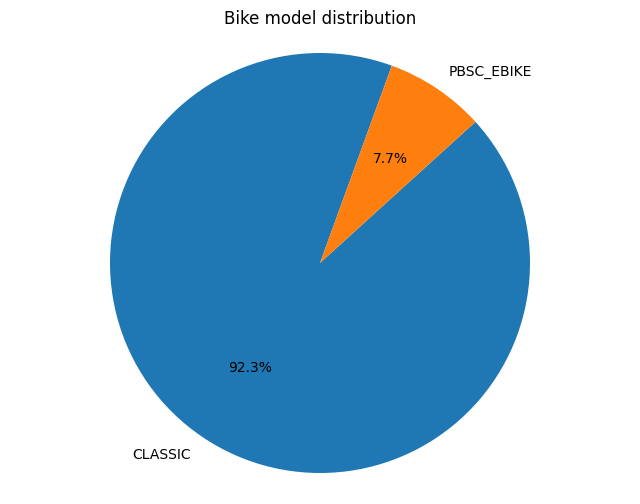

In [9]:
# Bike model distribution

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(df['Bike model'].value_counts(), labels=df['Bike model'].unique(), autopct='%1.1f%%', startangle=70)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Bike model distribution')

# Show the plot
plt.show()

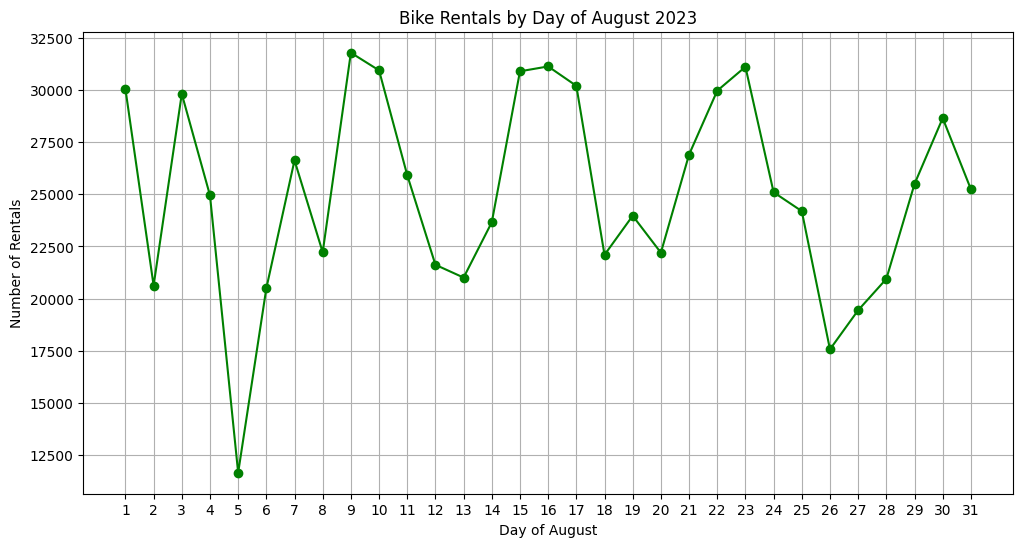

In [10]:
# Analyzing daily trends
daily_counts = df.groupby('Start day').size()
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', marker='o', linestyle='-', color='green')
plt.title('Bike Rentals by Day of August 2023')
plt.xlabel('Day of August')
plt.ylabel('Number of Rentals')
plt.xticks(range(1,32))
plt.grid(True)
plt.show()

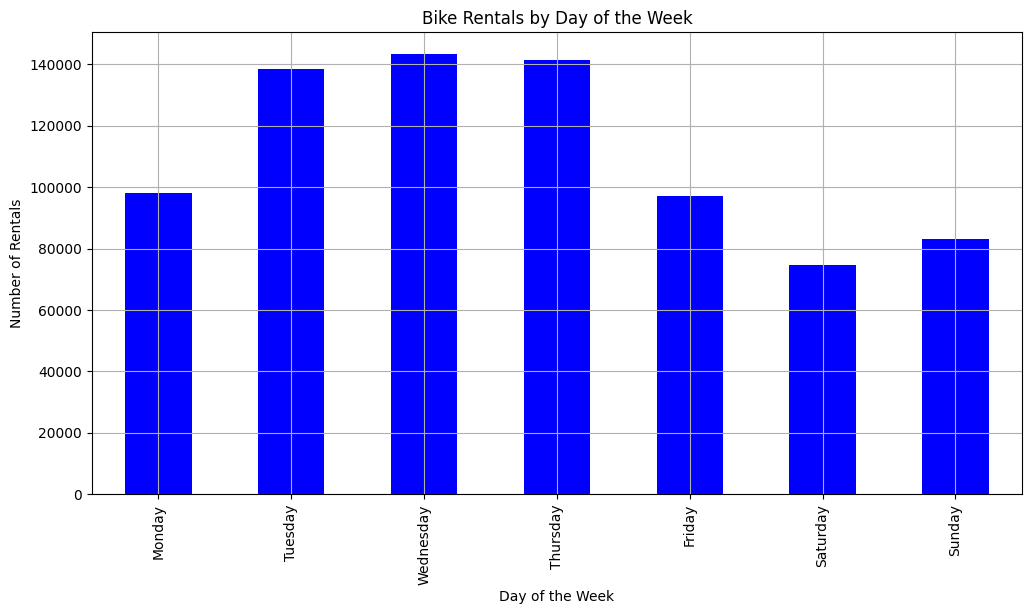

In [11]:
# Analyzing weekly trends
weekly_counts = df.groupby('Start day of week').size().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.figure(figsize=(12, 6))
weekly_counts.plot(kind='bar', color='blue')
plt.title('Bike Rentals by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rentals')
plt.grid(True)
plt.show()

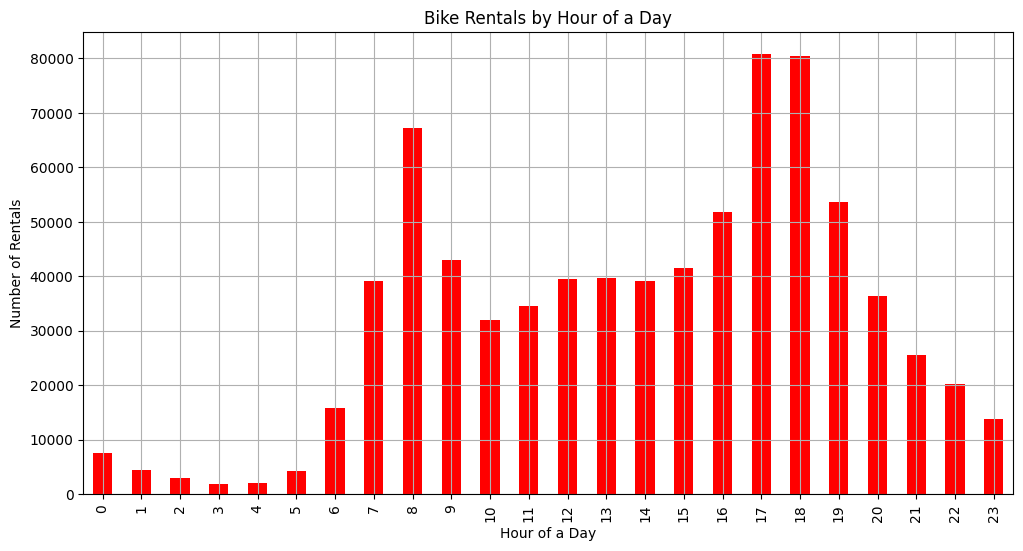

In [12]:
# Analyzing hourly trends
hourly_counts = df.groupby('Start hour').size()
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='bar', color='red')
plt.title('Bike Rentals by Hour of a Day')
plt.xlabel('Hour of a Day')
plt.ylabel('Number of Rentals')
plt.grid(True)
plt.show()

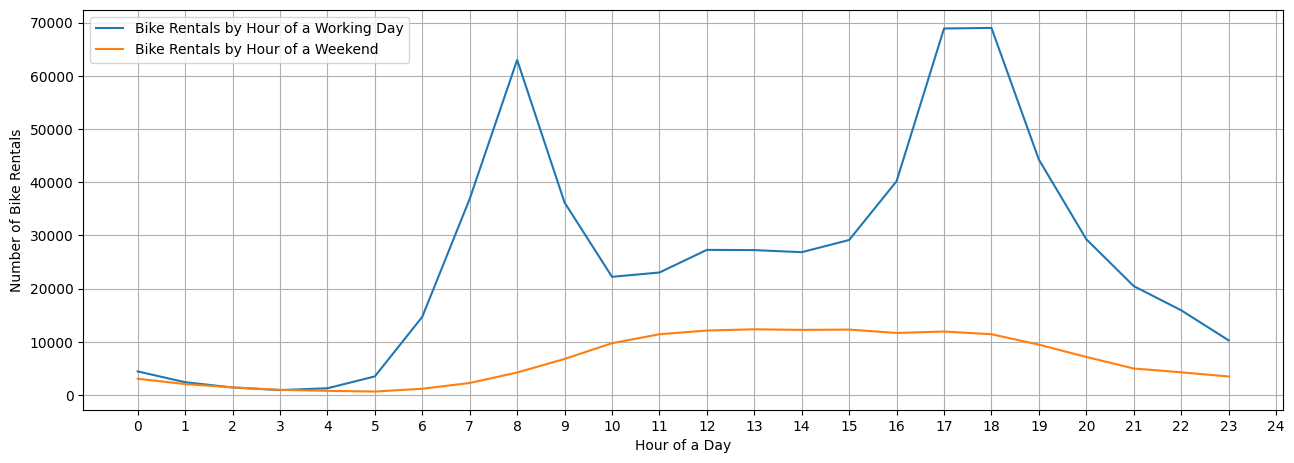

In [13]:
# Select working days (Monday to Friday)
working_days_df = df[df['Start day of week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

# Select weekend days (Saturday and Sunday)
weekend_df = df[df['Start day of week'].isin(['Saturday', 'Sunday'])]

fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0, 0, 1, 1])

# Plotting the Number of Bike Rentals during working days
ax.plot(working_days_df.groupby('Start hour').size(), label = 'Bike Rentals by Hour of a Working Day')

# Plotting the Number of Bike Rentals during weekend
ax.plot(weekend_df.groupby('Start hour').size(), label = 'Bike Rentals by Hour of a Weekend')

# Adding x and y label names
plt.xlabel('Hour of a Day')
plt.ylabel('Number of Bike Rentals')
plt.xticks(range(0,25))
plt.grid(True)
ax.legend(loc=0)

Text(120.72222222222221, 0.5, 'Hour of the Day')

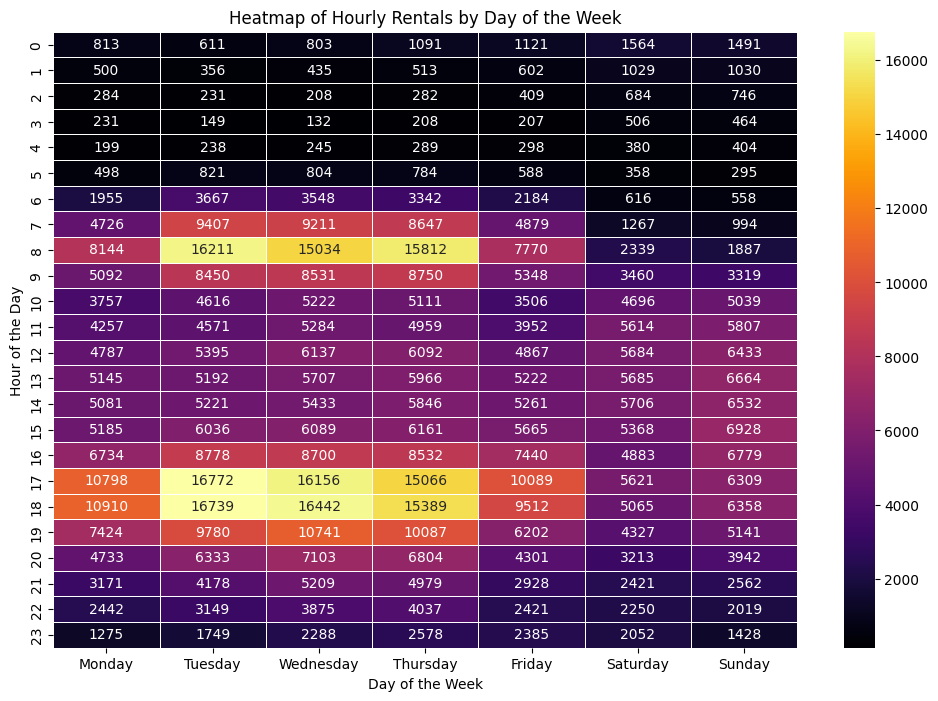

In [14]:
# Heatmap of Hourly Rentals by Day of the Week

pivot_table = df.pivot_table(index='Start hour', columns='Start day of week', values='Number', aggfunc='count')

# The order of days is alphabetical, we need to rearrange it
pivot_table = pivot_table[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

plt.figure(figsize=(12, 8))

sns.heatmap(pivot_table, cmap='inferno', linewidths=.5, annot=True, fmt=".0f")
plt.title('Heatmap of Hourly Rentals by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')

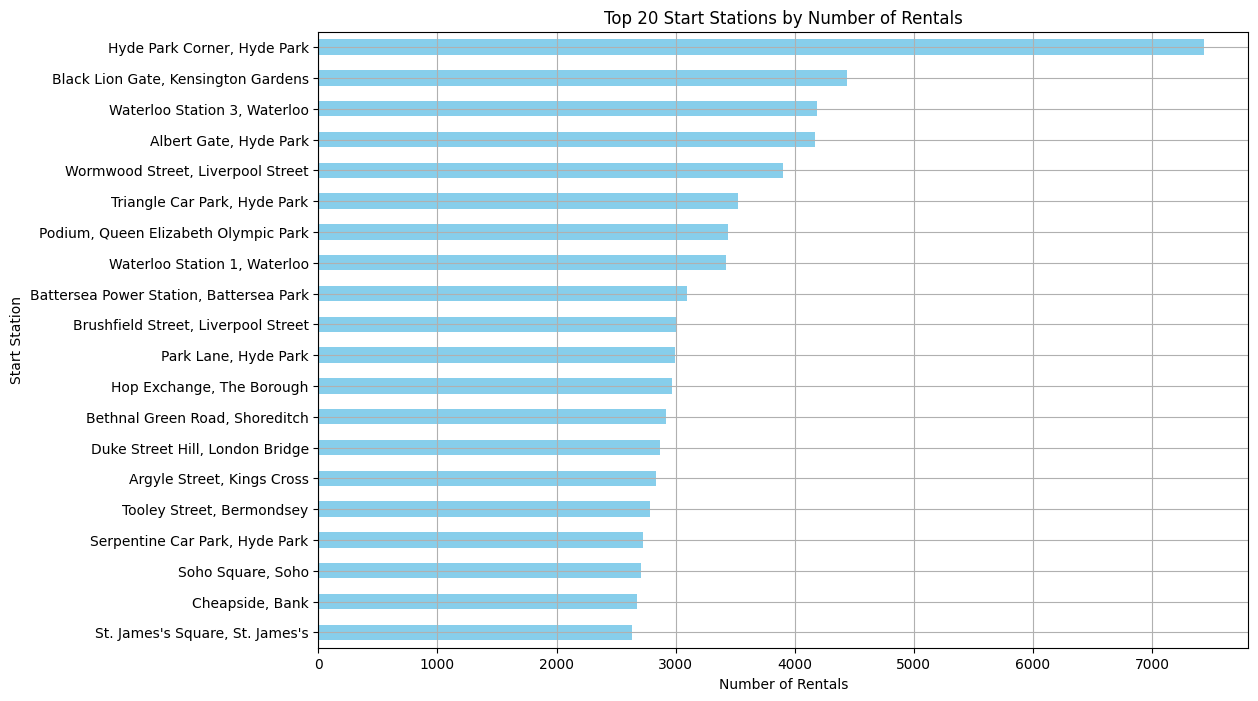

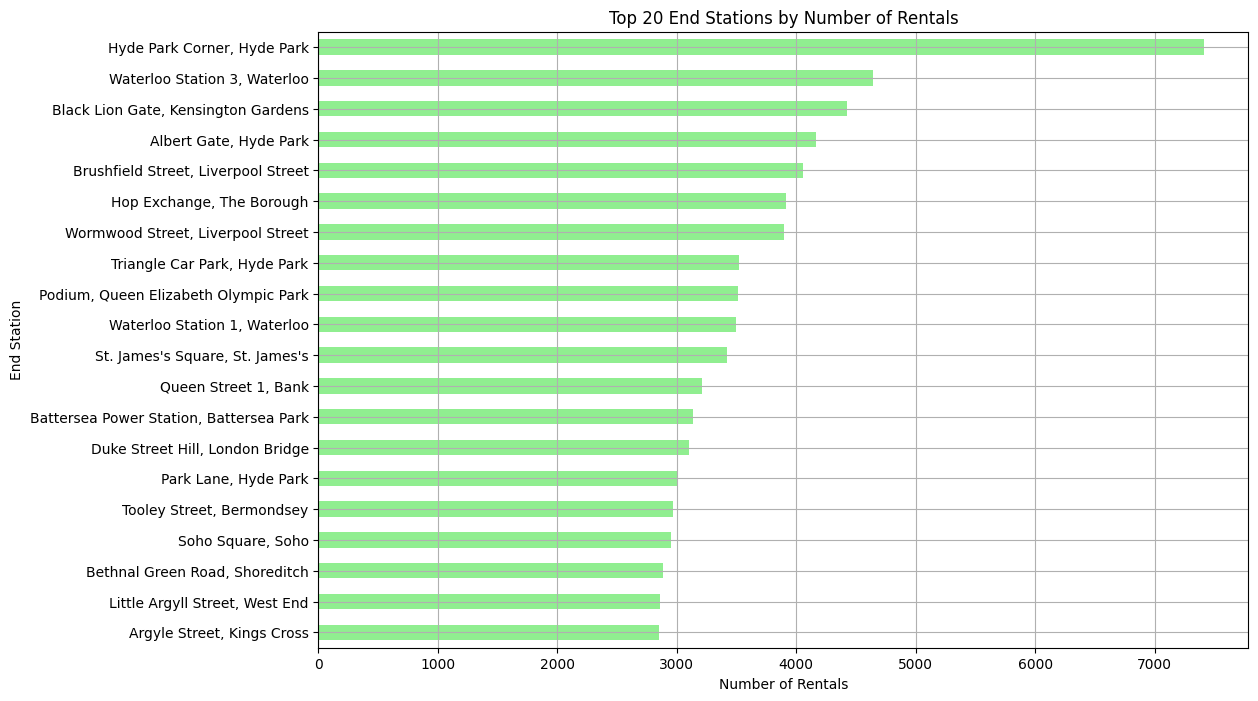

In [15]:
# Analyze the frequency of bike rentals across different start stations
start_station_counts = df['Start station'].value_counts().head(20)[::-1]  # Top 20 stations
plt.figure(figsize=(12, 8))
start_station_counts.plot(kind='barh', color='skyblue')
plt.title('Top 20 Start Stations by Number of Rentals')
plt.xlabel('Number of Rentals')
plt.ylabel('Start Station')
plt.grid(True)

# Analyze the frequency of bike rentals across different end stations
end_station_counts = df['End station'].value_counts().head(20)[::-1]  # Top 20 stations
plt.figure(figsize=(12, 8))
end_station_counts.plot(kind='barh', color='lightgreen')
plt.title('Top 20 End Stations by Number of Rentals')
plt.xlabel('Number of Rentals')
plt.ylabel('End Station')
plt.grid(True)


/tmp/ipykernel_19/2252887521.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Total duration (min)'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Total duration (min)', ylabel='Density'>

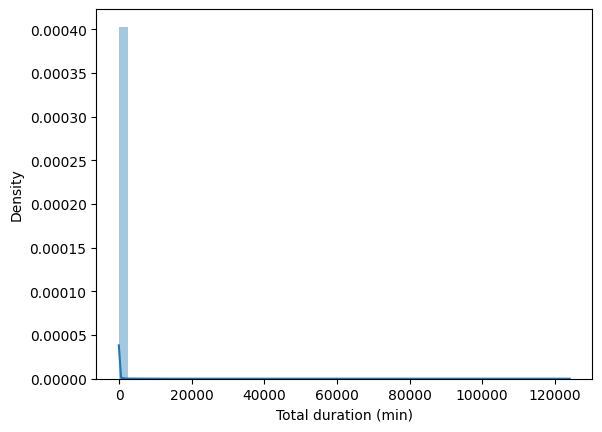

In [16]:
# Total duration of trips in minutes
sns.distplot(df['Total duration (min)'])

There are clearly outliers here. Let's try another approach.

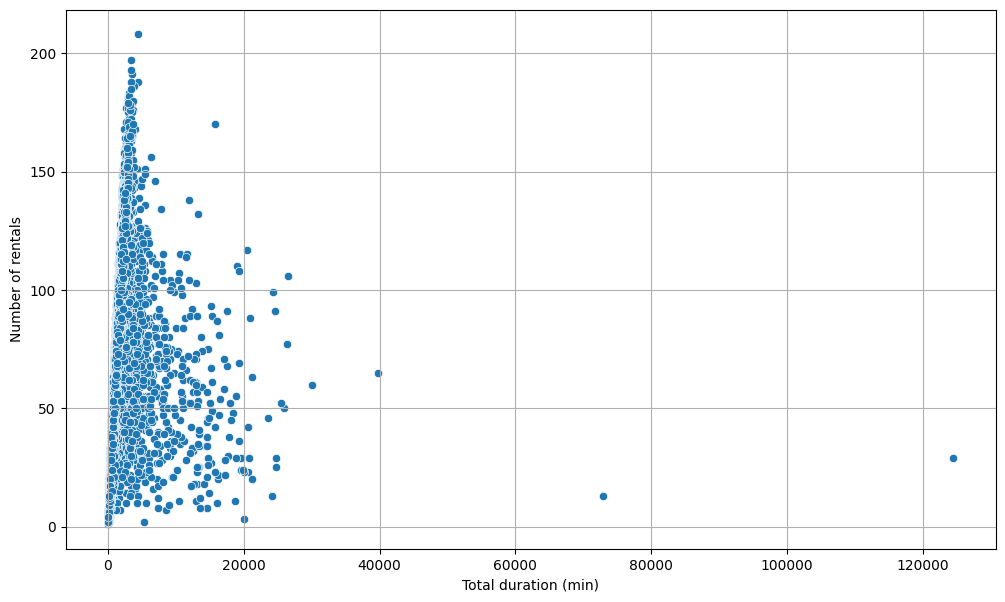

In [17]:
# Group the data by 'bike number' and calculate the total duration for each bike
bike_duration = df.groupby('Bike number')['Total duration (min)'].sum()

# Count the frequency of occurrences of each bike number to get the number of rentals
bike_rentals = df['Bike number'].value_counts()

# Create a DataFrame with bike number, total duration, and number of rentals
bike_stats = pd.DataFrame({'Total duration (min)': bike_duration, 'Number of rentals': bike_rentals})

# Analyze the trends in number of rentals vs total trip duration
plt.figure(figsize=(12,7))
sns.scatterplot(x='Total duration (min)', y='Number of rentals', data=bike_stats)
plt.grid(True)

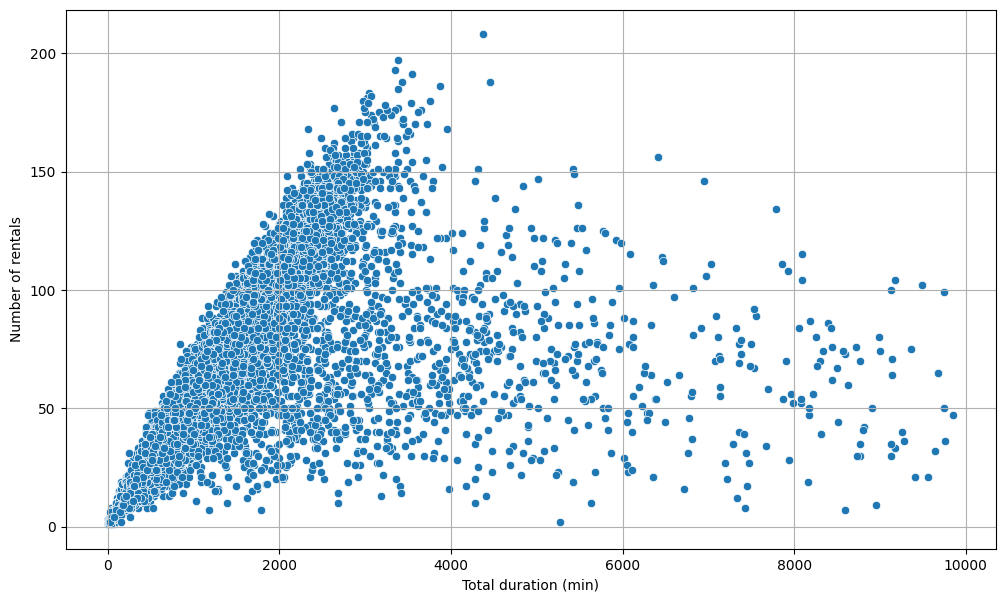

In [18]:
# Analyze the trends in number of rentals vs total trip duration (but only less than 10000 minutes)
plt.figure(figsize=(12,7))
sns.scatterplot(x=bike_stats[bike_stats['Total duration (min)']<10000]['Total duration (min)'], y='Number of rentals', data=bike_stats)
plt.grid(True)

In [19]:
# The most common trip duration in minutes
print(np.median(df['Total duration (min)']))

13.9795


# Maps

In [20]:
import cufflinks as cf
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) # this connects javascript with notebook
!pip install chart_studio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.7 MB/s eta 0:00:00


In [21]:
maps_df = df.dropna()

"""
# This dataset is too big to make an interactive map here. But, here's the code:

# Make interactive map of station locations
fig = px.scatter_mapbox(maps_df, 
                        lat='Start Latitude', 
                        lon='Start Longitude',
                        color_discrete_map={'green': 'green'},
                        hover_name='Start station',  # Column in 'df' containing names of locations
                        mapbox_style="carto-positron",
                        center={"lat": 51.5074, "lon": -0.1278},  # Coordinates for London
                        zoom=10,
                        opacity=0.5,
                        )

fig.iplot()
"""

'\n# This dataset is too big to make an interactive map here. But, here\'s the code:\n\n# Make interactive map of station locations\nfig = px.scatter_mapbox(maps_df, \n                        lat=\'Start Latitude\', \n                        lon=\'Start Longitude\',\n                        color_discrete_map={\'green\': \'green\'},\n                        hover_name=\'Start station\',  # Column in \'df\' containing names of locations\n                        mapbox_style="carto-positron",\n                        center={"lat": 51.5074, "lon": -0.1278},  # Coordinates for London\n                        zoom=10,\n                        opacity=0.5,\n                        )\n\nfig.iplot()\n'

<Axes: xlabel='Start Longitude', ylabel='Start Latitude'>

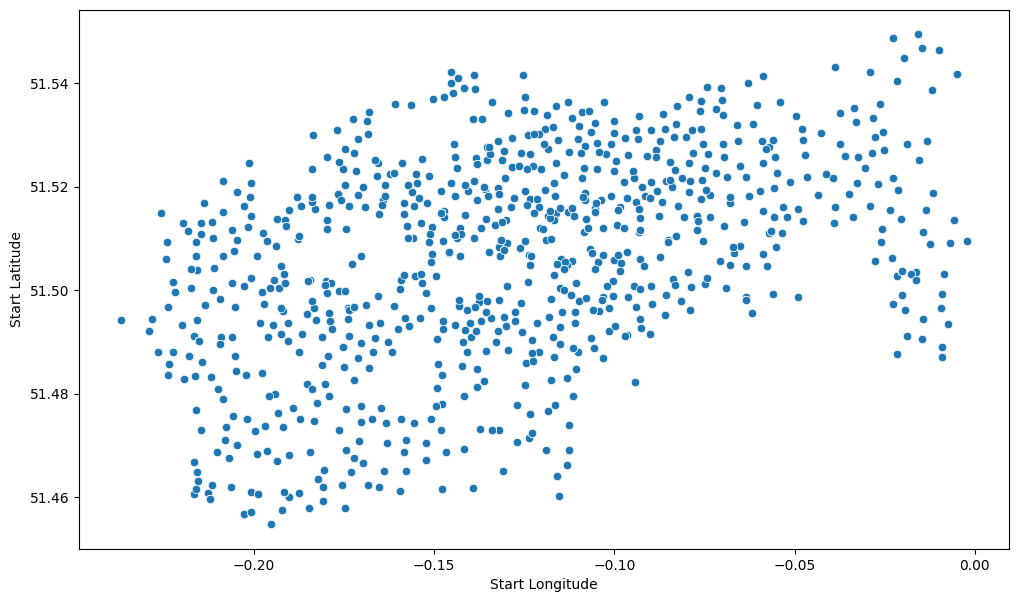

In [22]:
# Simple scatterplot that shows the location of stations
plt.figure(figsize=(12,7))
sns.scatterplot(x='Start Longitude', y='Start Latitude', data=maps_df)

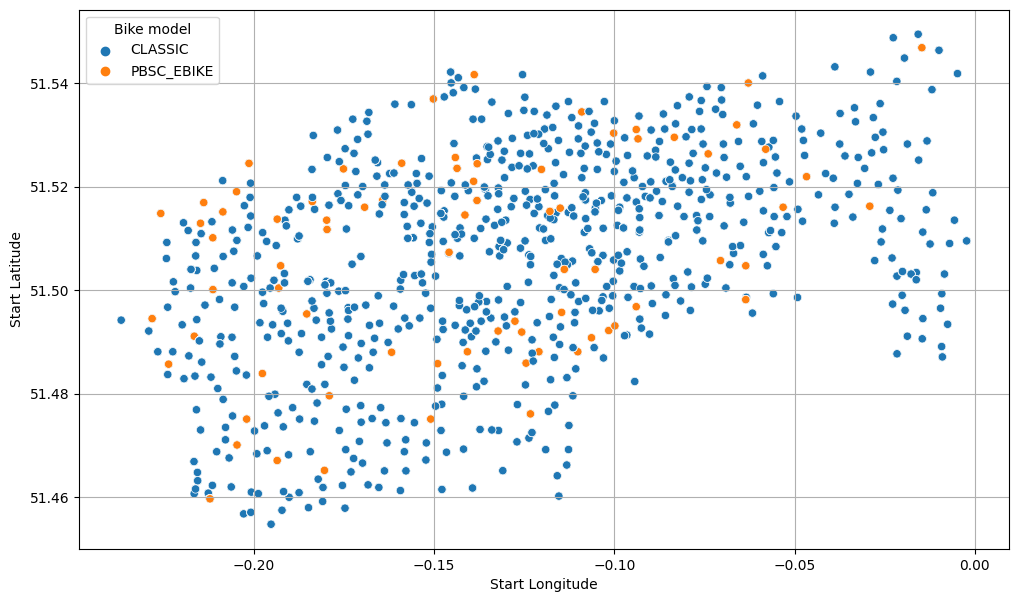

In [23]:
# Analyze the Bike model usage in reference to location
plt.figure(figsize=(12,7))
sns.scatterplot(x='Start Longitude', y='Start Latitude', data=maps_df, hue='Bike model')
plt.grid(True)

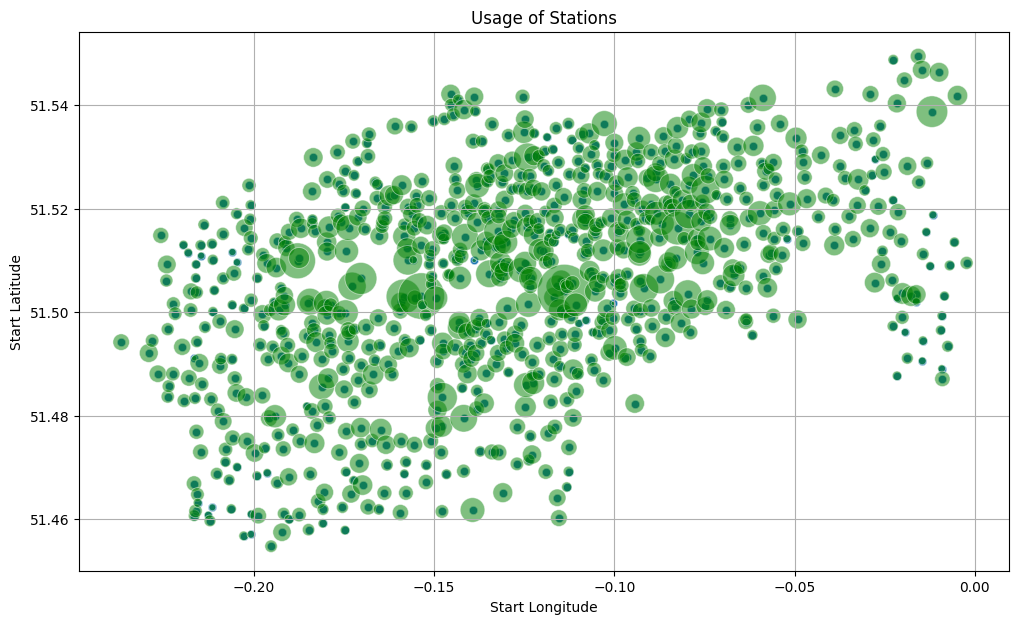

In [24]:
# We can change the size of the dots by some kind of column or function

# Create a scatter plot
plt.figure(figsize=(12,7))
sns.scatterplot(x='Start Longitude', y='Start Latitude', data=maps_df, alpha=0.5)  # 'alpha' parameter controls transparency for better visualization

# Calculate the frequency of each point
frequency = maps_df.groupby(['Start Longitude', 'Start Latitude']).size().reset_index(name='freq')

# Scale the frequency to use it as the size of points
size = frequency['freq'] * 0.15 # Adjust the scaling factor as needed for better visualization

# Plot the scatter plot again, this time specifying the size of each point based on its frequency
sns.scatterplot(x=frequency['Start Longitude'], y=frequency['Start Latitude'], data=frequency, s=size, color='green', alpha=0.5)  # You can change color and alpha as needed

# Add labels and title
plt.xlabel('Start Longitude')
plt.ylabel('Start Latitude')
plt.title('Usage of Stations')
plt.grid(True)

# Show the plot
plt.show()

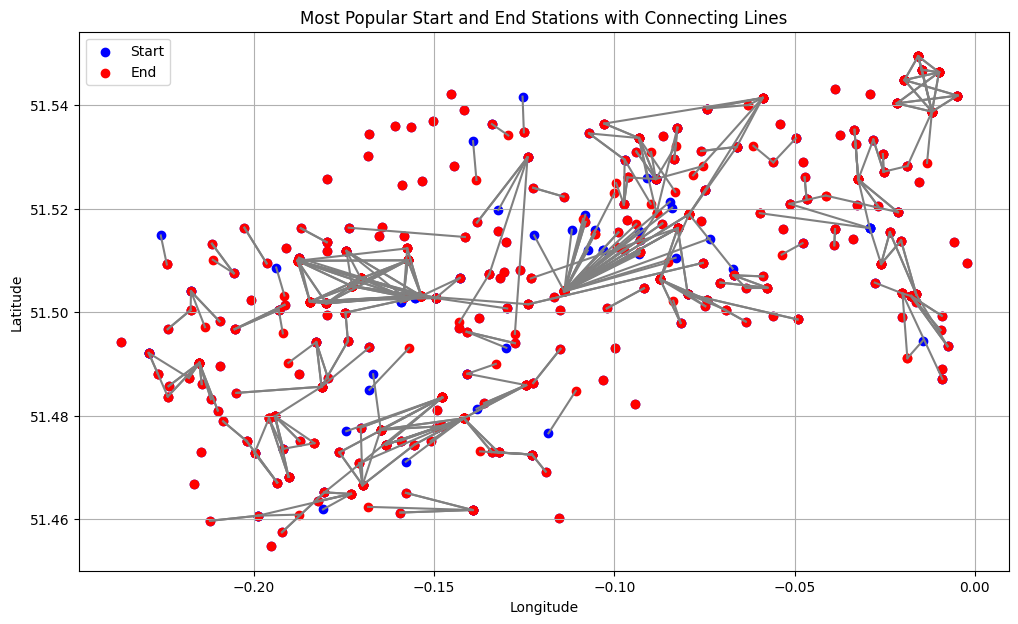

In [25]:
# Analyze popular routes

grouped_data = maps_df.groupby(['Start station', 'End station']).agg({
    'Start Latitude': 'first',   # Take the first value
    'Start Longitude': 'first',  # Take the first value
    'End Latitude': 'first',     # Take the first value
    'End Longitude': 'first',    # Take the first value
})

# Reset the index to make the grouped columns accessible
grouped_data.reset_index(inplace=True)

# Add a new column to indicate the count of 'Start station'-'End station' pairs
pair_counts = maps_df.groupby(['Start station', 'End station']).size()
grouped_data['Pair Count'] = grouped_data.apply(lambda row: pair_counts.get((row['Start station'], row['End station']), 0), axis=1)

# Take only popular routes from the grouped_data
popular_routes = grouped_data[grouped_data['Pair Count']>50]

# Plot start and end stations
plt.figure(figsize=(12,7))
plt.scatter(popular_routes['Start Longitude'], popular_routes['Start Latitude'], color='blue', label='Start')
plt.scatter(popular_routes['End Longitude'], popular_routes['End Latitude'], color='red', label='End')

# Plot lines connecting start and end stations
for index, row in popular_routes.iterrows():
    plt.plot([row['Start Longitude'], row['End Longitude']],
             [row['Start Latitude'], row['End Latitude']], color='gray')

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Most Popular Start and End Stations with Connecting Lines')
plt.legend()
plt.grid(True)

plt.show()

# ML Model

In [26]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | / done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 86.9 MB/s eta 0:

In [27]:
from pycaret.regression import *


In [28]:
# Pick relevant columns
bike_columns = df[['Bike number', 'Start date 1', 'Total duration (min)', 'Start day', 'Start hour']]
bike_columns = bike_columns.groupby(['Start day', 'Start hour']).agg({
    'Bike number': 'count'
}).reset_index()
bike_columns.rename(columns={'Bike number': 'Trip Count'}, inplace=True)

# Split data into train-test set
train = bike_columns[bike_columns['Start day'] < 28]
test = bike_columns[bike_columns['Start day'] >= 28]

# check shape
train.shape, test.shape

((645, 3), (96, 3))

In [29]:
# initialize setup
s = setup(
    data = train, 
    test_data = test, 
    target = 'Trip Count', 
    fold_strategy = 'timeseries', 
    numeric_features = ['Start day', 'Start hour'], 
    fold = 3, 
    transform_target = False, 
    session_id = 123,
    data_split_shuffle=False,
    fold_shuffle=False
)

,Description,Value
0,Session id,123
1,Target,Trip Count
2,Target type,Regression
3,Original data shape,"(741, 3)"
4,Transformed data shape,"(741, 3)"
5,Transformed train set shape,"(645, 3)"
6,Transformed test set shape,"(96, 3)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


In [30]:
# Training machine learning models
best_model = compare_models(sort = 'MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,377.8012,357350.4431,590.8223,0.5262,0.5988,0.4795,0.0200
rf,Random Forest Regressor,358.8287,318092.7817,556.3905,0.5788,0.5258,0.4876,0.1300
et,Extra Trees Regressor,393.1497,367980.2093,601.5767,0.5118,0.6156,0.5208,0.0967
xgboost,Extreme Gradient Boosting,400.2714,381708.4564,614.2108,0.4940,0.6340,0.5240,0.0667
lightgbm,Light Gradient Boosting Machine,349.9192,277179.9015,526.4150,0.6342,0.5879,0.5586,0.2600
catboost,CatBoost Regressor,411.3307,395437.3936,625.2624,0.4793,0.7062,0.5670,0.6233
gbr,Gradient Boosting Regressor,381.7060,327775.4255,572.0988,0.5672,0.6035,0.6070,0.0600
knn,K Neighbors Regressor,392.4451,378566.6891,612.3911,0.4996,0.6280,0.6395,0.0233
ada,AdaBoost Regressor,353.2022,276905.1936,525.7859,0.6351,0.5613,0.6643,0.0500
par,Passive Aggressive Regressor,676.5152,888822.2161,939.7544,-0.1759,1.0735,1.2793,0.0167


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [31]:
# Make a dataframe of dates and hours for future predictions
future_dates = pd.date_range(start = '2023-09-01 00:00:00', end = '2023-09-15 23:59:59', freq = 'H')
future_df = pd.DataFrame()
future_df['Start day'] = [i.day for i in future_dates]
future_df['Start hour'] = [i.hour for i in future_dates]    
future_df.head()

,Start day,Start hour
0,1,0
1,1,1
2,1,2
3,1,3
4,1,4


In [32]:
# Make predictions
predictions_future = predict_model(best_model, data=future_df)
predictions_future.head()

,Start day,Start hour,prediction_label
0,1,0,171.0
1,1,1,108.0
2,1,2,83.0
3,1,3,37.0
4,1,4,47.0


In [33]:
# Plot the predictions
concat_df = pd.concat([bike_columns, predictions_future], axis=0)
concat_df_i = pd.date_range(start='2023-08-01 00:00:00', end = '2023-09-15 23:59:59', freq = 'H')

# There are 3 hours missing from concat_df, so this code won't work without dropping these 3 hours from concat_df_i
# Create a sample DataFrame with a DatetimeIndex
data = {
    'Value': range(len(concat_df_i))
}
sample_df = pd.DataFrame(data, index=concat_df_i)

# Specify the date and hours to drop
date_to_drop = '2023-08-22'
hours_to_drop = [1, 2, 3] 

# Create a boolean mask to filter out the specific hours
mask = ~((sample_df.index.date == pd.to_datetime(date_to_drop).date()) & (sample_df.index.hour.isin(hours_to_drop)))

# Apply the mask to the DataFrame
filtered_df = sample_df[mask]

# Convert DatetimeIndex to Series
index_series = filtered_df.index.to_series()

concat_df.set_index(index_series, inplace=True)
concat_df.head()


fig = px.line(concat_df, x=concat_df.index, y=["Trip Count", "prediction_label"], template = 'plotly_dark')
fig.show()
